<a href="https://colab.research.google.com/github/Vijce/Group-16-Final-Project/blob/main/Fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
import json
import requests

In [ ]:
!pip install transformers

# Load Data

In [ ]:
import os
print(os.getcwd())
print(os.listdir())


/content
['.config', 'seniority-v2.csv', 'predict.json', 'test.json', 'department-v2.csv', 'sample_data']


In [ ]:
df_department = pd.read_csv('department-v2.csv')
df_department['text'] = df_department['text'].str.lower()

display(df_department)
display(df_department.isna().sum())
pd.unique(df_department['label'])

,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
10140,vp sales d.a.ch.,Sales
10141,vp sales dach,Sales
10142,vp sales development & strategy,Sales
10143,vp sales germany,Sales


,0
text,0
label,0


array(['Marketing', 'Project Management', 'Administrative',
       'Business Development', 'Consulting', 'Human Resources',
       'Information Technology', 'Other', 'Purchasing', 'Sales',
       'Customer Support'], dtype=object)

In [ ]:
df_seniority = pd.read_csv('seniority-v2.csv')
df_seniority['text'] = df_seniority['text'].str.lower()

display(df_seniority, df_seniority.isna().sum())
pd.unique(df_seniority['label'])

,text,label
0,analyst,Junior
1,analyste financier,Junior
2,anwendungstechnischer mitarbeiter,Junior
3,application engineer,Senior
4,applications engineer,Senior
...,...,...
9423,vp sales d.a.ch.,Management
9424,vp sales dach,Management
9425,vp sales development & strategy,Management
9426,vp sales germany,Management


,0
text,0
label,0


array(['Junior', 'Senior', 'Lead', 'Management', 'Director'], dtype=object)

In [ ]:
file_path_annotated = 'test.json'
file_path_tobepredict = 'predict.json'

def read_json_file(file_path):
  with open(file_path, 'r', encoding="utf-8") as file:
      jason_data = json.load(file)

  flat_data = []
  for item in jason_data:
      for subitem in item:
          flat_data.append(subitem)

  df = pd.DataFrame(flat_data)
  return df

df = read_json_file(file_path_annotated)
df_predict = read_json_file(file_path_tobepredict)

display(df,df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  2638 non-null   object
 1   linkedin      2638 non-null   object
 2   position      2638 non-null   object
 3   startDate     2520 non-null   object
 4   endDate       1897 non-null   object
 5   status        2638 non-null   object
 6   department    2638 non-null   object
 7   seniority     2638 non-null   object
dtypes: object(8)
memory usage: 165.0+ KB


,organization,linkedin,position,startDate,endDate,status,department,seniority
0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,None,ACTIVE,Other,Management
1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,None,ACTIVE,Other,Professional
3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,None,ACTIVE,Other,Management
4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
...,...,...,...,...,...,...,...,...
2633,Bistum,,Justitiar,2014-03,None,ACTIVE,Other,Professional
2634,FORESTA Management,,Geschäftsführer,2010-01,None,ACTIVE,Other,Management
2635,Malteser Hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,Präsidium,1999,None,ACTIVE,Other,Management
2636,Spies & Brunner RAe,,Rechtsanwalt,1995-01,None,ACTIVE,Other,Professional


None

In [ ]:
df[['position', 'status', 'organization']] = df[['position', 'status', 'organization']].apply(lambda x: x.str.lower())
df

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management
2636,spies & brunner rae,,rechtsanwalt,1995-01,None,active,Other,Professional


In [ ]:
df_linkedin = df.copy()
df_linkedin = df_linkedin[df_linkedin['status'] != 'inactive']
df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [ ]:
display(df_predict,df_predict.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  1886 non-null   object
 1   linkedin      1886 non-null   object
 2   position      1886 non-null   object
 3   startDate     1828 non-null   object
 4   endDate       1409 non-null   object
 5   status        1886 non-null   object
dtypes: object(6)
memory usage: 88.5+ KB


,organization,linkedin,position,startDate,endDate,status
0,"Keeping The Books, Bookkeeping",,Bookkeeper,2023-03,None,ACTIVE
1,Playful Paws,,Co-Owner,2018-11,None,ACTIVE
2,S&R services,,Logistics Officer,2019-09,2024-04,INACTIVE
3,ABC Supply Co. Inc.,https://www.linkedin.com/company/abc-supply,Truck driver/ laborer,2019-03,2019-09,INACTIVE
4,MB Railways,,Fuel Driver,2018-03,2019-03,INACTIVE
...,...,...,...,...,...,...
1881,Euler Hermes Deutschland,https://www.linkedin.com/company/allianz-trade...,Juristischer Berater,1996-03,None,ACTIVE
1882,Folkwang Universität der Künste,,"Leitung Personal, Finanzen, Einkauf, IT | Folk...",2015-07,None,ACTIVE
1883,Landesspracheninstitut in der Ruhr-Universität...,,Verwaltungsleitung Landesspracheninstitut in d...,2005-10,2015-06,INACTIVE
1884,Folkwang Universität der Künste,,"Leitung Gebäudemanagement, Einkauf und Control...",2004-03,2005-09,INACTIVE


None

# Fine-tuning

In [ ]:
X1 = df_department['text']
X2 = df_seniority['text']
y1 = df_department['label']
y2 = df_seniority['label']

In [ ]:
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(
    X1,
    y1,
    test_size=0.2,
    random_state=42)

X_train_sen, X_test_sen, y_train_sen, y_test_sen = train_test_split(
    X2,
    y2,
    test_size=0.2,
    random_state=42)

print("Department train/test:", len(X_train_dep), len(X_test_dep))
print("Seniority  train/test:", len(X_train_sen), len(X_test_sen))

Department train/test: 8116 2029
Seniority  train/test: 7542 1886


!pip install transformers torch accelerate

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

class TextClsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            #padding="max_length",
            #max_length=self.max_len,
            return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
labels_dep = pd.Index(np.unique(np.concatenate([y_train_dep, y_test_dep]))).sort_values()
label2id_dep = {lab: i for i, lab in enumerate(labels_dep)}
id2label_dep = {i: lab for lab, i in label2id_dep.items()}

y_train_dep_id = pd.Series(y_train_dep).map(label2id_dep)
y_test_dep_id  = pd.Series(y_test_dep).map(label2id_dep)

In [ ]:
train_ds_dep = TextClsDataset(X_train_dep, y_train_dep_id, tokenizer)
test_ds_dep = TextClsDataset(X_test_dep, y_test_dep_id, tokenizer)

print("Train dataset size:", len(train_ds_dep))
print("Test dataset size:", len(test_ds_dep))
print("Num classes:", len(labels_dep))

Train dataset size: 8116
Test dataset size: 2029
Num classes: 11


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
model_dep = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(labels_dep),
    id2label={i: lab for i, lab in enumerate(labels_dep)},
    label2id={lab: i for i, lab in enumerate(labels_dep)})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")}

In [ ]:
training_args = TrainingArguments(
    output_dir="./dep_distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.05,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro")

In [ ]:
trainer_dep = Trainer(
    model=model_dep,
    args=training_args,
    train_dataset=train_ds_dep,
    eval_dataset=test_ds_dep,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

trainer_dep.train()
trainer_dep.evaluate()

/tmp/ipython-input-3171256691.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_dep = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.081900,0.088217,0.982750,0.684915,0.978120
2,0.029900,0.046466,0.992607,0.965133,0.992587
3,0.027300,0.045323,0.992607,0.974047,0.992611
4,0.012500,0.045462,0.993593,0.976675,0.993590
5,0.026400,0.047194,0.993100,0.975399,0.993095
6,0.011100,0.048100,0.993100,0.974096,0.993097


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

{'eval_loss': 0.045461587607860565,
 'eval_accuracy': 0.9935929029078364,
 'eval_f1_macro': 0.9766749602879454,
 'eval_f1_weighted': 0.99359008885678,
 'eval_runtime': 52.0294,
 'eval_samples_per_second': 38.997,
 'eval_steps_per_second': 1.23,
 'epoch': 6.0}

In [ ]:
# JUST A TEST
pred_logits = trainer_dep.predict(test_ds_dep).predictions
pred_ids = pred_logits.argmax(axis=1)

pred_labels = pd.Series(pred_ids).map(id2label_dep)
pred_labels.value_counts().head(20)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,count
Marketing,855
Sales,659
Information Technology,267
Business Development,138
Consulting,33
Project Management,32
Other,12
Administrative,11
Customer Support,10
Purchasing,8


In [ ]:
from sklearn.metrics import classification_report

true_labels = y_test_dep_id.map(id2label_dep)
print(classification_report(true_labels, pred_labels, digits=4))

                        precision    recall  f1-score   support

        Administrative     1.0000    1.0000    1.0000        11
  Business Development     1.0000    0.9857    0.9928       140
            Consulting     0.9697    0.9697    0.9697        33
      Customer Support     1.0000    1.0000    1.0000        10
       Human Resources     1.0000    0.8000    0.8889         5
Information Technology     0.9738    0.9848    0.9793       264
             Marketing     0.9965    0.9977    0.9971       854
                 Other     1.0000    1.0000    1.0000        12
    Project Management     1.0000    0.9697    0.9846        33
            Purchasing     0.8750    1.0000    0.9333         7
                 Sales     0.9985    0.9970    0.9977       660

              accuracy                         0.9936      2029
             macro avg     0.9830    0.9731    0.9767      2029
          weighted avg     0.9937    0.9936    0.9936      2029



Json test

In [ ]:
df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [ ]:
df_test = df_linkedin.copy()
df_test = df_test[df_test["status"] != "inactive"].copy()

X_json_dep = df_test["position"].fillna("").astype(str)
y_json_dep_raw = df_test["department"].fillna("").astype(str)

# unknown to Other
OTHER_LABEL = "Other"
if OTHER_LABEL not in label2id_dep:
    raise ValueError(f'"{OTHER_LABEL}" not in training label2id_dep. Check your training labels.')

y_json_dep = y_json_dep_raw.where(y_json_dep_raw.isin(label2id_dep.keys()), OTHER_LABEL)
y_json_dep_id = y_json_dep.map(label2id_dep)

In [ ]:
(y_json_dep_raw != y_json_dep).value_counts()

,count
department,
False,741


In [ ]:
json_test_ds_dep = TextClsDataset(X_json_dep, y_json_dep_id, tokenizer)

pred_logits_json = trainer_dep.predict(json_test_ds_dep).predictions
pred_ids_json = pred_logits_json.argmax(axis=1)

pred_labels_json = pd.Series(pred_ids_json).map(id2label_dep)
true_labels_json = y_json_dep_id.map(id2label_dep)

from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(true_labels_json, pred_labels_json, digits=4, zero_division=0))

json_out_metrics = {
    "n_samples": len(df_test),
    "n_unknown_mapped_to_other": int((y_json_dep_raw != y_json_dep).sum()),
    "accuracy": accuracy_score(true_labels_json, pred_labels_json),
    "f1_macro": f1_score(true_labels_json, pred_labels_json, average="macro"),
    "f1_weighted": f1_score(true_labels_json, pred_labels_json, average="weighted")}
json_out_metrics

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                        precision    recall  f1-score   support

        Administrative     0.6000    0.1304    0.2143        23
  Business Development     0.3750    0.3000    0.3333        20
            Consulting     0.6562    0.4667    0.5455        45
      Customer Support     1.0000    0.1429    0.2500         7
       Human Resources     0.0636    0.7000    0.1167        20
Information Technology     0.1775    0.8750    0.2951        72
             Marketing     0.5556    0.4167    0.4762        24
                 Other     0.5000    0.0024    0.0047       422
    Project Management     0.6944    0.6098    0.6494        41
            Purchasing     0.4706    0.5000    0.4848        16
                 Sales     0.8462    0.6471    0.7333        51

              accuracy                         0.2497       741
             macro avg     0.5399    0.4355    0.3730       741
          weighted avg     0.5066    0.2497    0.1979       741



{'n_samples': 741,
 'n_unknown_mapped_to_other': 0,
 'accuracy': 0.2496626180836707,
 'f1_macro': 0.3730238319825812,
 'f1_weighted': 0.19793524623566786}

In [ ]:
def build_metrics(name, y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    out = {
        "name": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "report_df": pd.DataFrame(
            classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
        ).T}
    return out

,accuracy,f1_macro,f1_weighted
dataset,,,
CSV 20% test (in-dist),0.993593,0.976675,0.993590
JSON test (out-domain),0.249663,0.373024,0.197935


<Figure size 640x480 with 0 Axes>

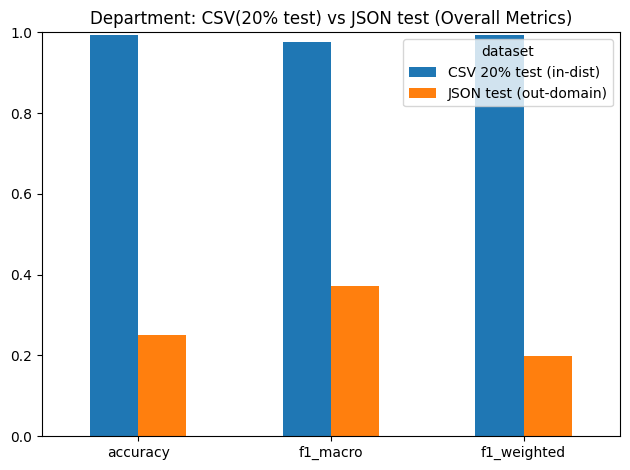

In [ ]:
CSV_TEST_20 = build_metrics("CSV 20% test (in-dist)", true_labels_out, pred_labels_out)
JSON_TEST   = build_metrics("JSON test (out-domain)", true_labels_json, pred_labels_json)

metrics_df = pd.DataFrame([
    {"dataset": CSV_TEST_20["name"], "accuracy": CSV_TEST_20["accuracy"], "f1_macro": CSV_TEST_20["f1_macro"], "f1_weighted": CSV_TEST_20["f1_weighted"]},
    {"dataset": JSON_TEST["name"],   "accuracy": JSON_TEST["accuracy"],   "f1_macro": JSON_TEST["f1_macro"],   "f1_weighted": JSON_TEST["f1_weighted"]},
]).set_index("dataset")

display(metrics_df)

plt.figure()
metrics_df.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.title("Department: CSV(20% test) vs JSON test (Overall Metrics)")
plt.tight_layout()
plt.show()


In [ ]:
def per_class_f1(report_df):
    drop_rows = ["accuracy", "macro avg", "weighted avg"]
    cls = report_df.drop(index=[r for r in drop_rows if r in report_df.index], errors="ignore")
    cls = cls[cls.index.notnull()]
    return cls["f1-score"].astype(float)

f1_csv = per_class_f1(CSV_TEST_20["report_df"])
f1_json = per_class_f1(JSON_TEST["report_df"])

<Figure size 640x480 with 0 Axes>

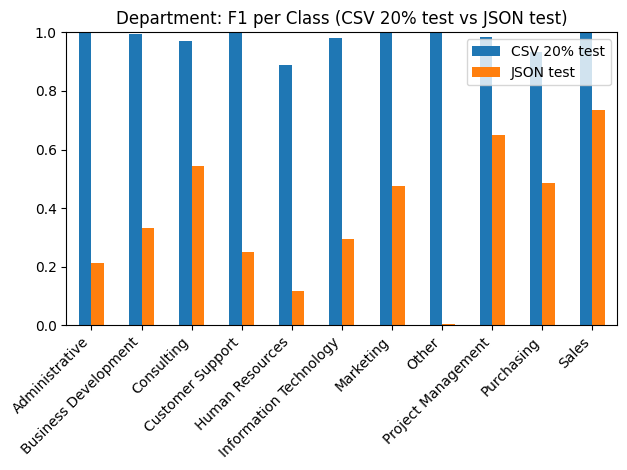

In [ ]:
all_classes = sorted(set(f1_csv.index).union(set(f1_json.index)))
f1_compare = pd.DataFrame({
    "CSV 20% test": f1_csv.reindex(all_classes),
    "JSON test": f1_json.reindex(all_classes),
}).fillna(0)

plt.figure()
f1_compare.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Department: F1 per Class (CSV 20% test vs JSON test)")
plt.tight_layout()
plt.show()

In [ ]:
print('hello world')

hello world


Weighted Fine-tuning

In [ ]:
# Use class weight
from transformers import Trainer

class_counts = y_train_dep_id.value_counts().sort_index()
num_classes = len(labels_dep)

weights = len(y_train_dep_id) / (num_classes * class_counts.values)
class_weights = torch.tensor(weights, dtype=torch.float)

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer_dep = WeightedTrainer(
    model=model_dep,
    args=training_args,
    train_dataset=train_ds_dep,
    eval_dataset=test_ds_dep,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights)

trainer_dep.train()
trainer_dep.evaluate()

/tmp/ipython-input-3731799178.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.000700,0.084831,0.989650,0.979852,0.989689
2,0.035100,0.087785,0.991621,0.984254,0.991629
3,0.000100,0.090836,0.992114,0.978822,0.992132
4,0.000100,0.088431,0.992114,0.977453,0.992138
5,0.001800,0.086431,0.993593,0.984247,0.993599
6,0.000000,0.091792,0.992607,0.970848,0.992643


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

{'eval_loss': 0.08778541535139084,
 'eval_accuracy': 0.9916214884179398,
 'eval_f1_macro': 0.9842535327387167,
 'eval_f1_weighted': 0.9916285467483942,
 'eval_runtime': 52.6305,
 'eval_samples_per_second': 38.552,
 'eval_steps_per_second': 1.216,
 'epoch': 6.0}

In [ ]:
pred_logits = trainer_dep.predict(test_ds_dep).predictions
pred_ids = pred_logits.argmax(axis=1)
pred_labels = pd.Series(pred_ids).map(id2label_dep)
pred_labels.value_counts().head(20)

In [ ]:
true_labels = y_test_dep_id.map(id2label_dep)
print(classification_report(true_labels, pred_labels, digits=4, zero_division=0))

                        precision    recall  f1-score   support

        Administrative     0.9167    1.0000    0.9565        11
  Business Development     1.0000    0.9857    0.9928       140
            Consulting     0.9143    0.9697    0.9412        33
      Customer Support     1.0000    1.0000    1.0000        10
       Human Resources     1.0000    1.0000    1.0000         5
Information Technology     0.9808    0.9697    0.9752       264
             Marketing     0.9930    0.9977    0.9953       854
                 Other     1.0000    1.0000    1.0000        12
    Project Management     1.0000    0.9394    0.9688        33
            Purchasing     1.0000    1.0000    1.0000         7
                 Sales     0.9970    0.9970    0.9970       660

              accuracy                         0.9916      2029
             macro avg     0.9820    0.9872    0.9843      2029
          weighted avg     0.9917    0.9916    0.9916      2029



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, pred_labels, labels=labels_dep)
cm_df = pd.DataFrame(cm, index=labels_dep, columns=labels_dep)
cm_df

Output of weighted fine-tuning

Weight's perform is better

In [ ]:
labels_seni = sorted(y_train_seni.unique())

label2id_seni = {lab: i for i, lab in enumerate(labels_seni)}
id2label_seni = {i: lab for lab, i in label2id_seni.items()}

y_train_seni_id = y_train_seni.map(label2id_seni)
y_test_seni_id  = y_test_seni.map(label2id_seni)
train_ds_seni = TextClsDataset(X_train, y_train_seni_id, tokenizer)
test_ds_seni  = TextClsDataset(X_test,  y_test_seni_id,  tokenizer)

print("Train:", len(train_ds_seni))
print("Test :", len(test_ds_seni))
print("Classes:", len(labels_seni))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_seni = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(labels_seni)),
    y=y_train_seni_id.values
)

class_weights_seni = torch.tensor(class_weights_seni, dtype=torch.float)
print(class_weights_seni)

In [ ]:
import torch.nn as nn
model_seni = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(labels_seni),
    id2label=id2label_seni,
    label2id=label2id_seni)

def compute_metrics_seni(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args_seni = TrainingArguments(
    output_dir="./seni_distilbert_weight",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none")

trainer_seni = WeightedTrainer(
    model=model_seni,
    args=training_args_seni,
    train_dataset=train_ds_seni,
    eval_dataset=test_ds_seni,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_seni,
    class_weights=class_weights_seni)

trainer_seni.train()
trainer_seni.evaluate()

In [ ]:
pred_logits = trainer_seni.predict(test_ds_seni).predictions
pred_ids = pred_logits.argmax(axis=1)

pred_labels = pd.Series(pred_ids).map(id2label_seni)
true_labels = y_test_seni_id.map(id2label_seni)

print(classification_report(true_labels, pred_labels, digits=4, zero_division=0))